In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


59

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(30,31):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.30
(1200, 36, 256)
(1200,) (390,) (810,)
(1200,) (600,) (600,)


3576

In [ ]:
def simple_2D_CNN(x): 
  y = AvgPool2D(pool_size=(1,window_size))(x)
  y = Flatten()(y)
  y = Dense(4,activation='tanh') (y)
  y = Dense(no_new_channels,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x) #above 8 Hz
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x) #above 12.8 Hz
  x3 = Conv2D(filters = 32, kernel_size = (1,6), strides = (1,1), padding = 'same', activation='selu')(x) #above 21.3 Hz
  x1 = Subtract()([x1, x2]) #above 8 Hz and below 12.8 Hz
  x1 = MaxPool2D(pool_size=(1,2))(x1) #downsampling by 2
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Subtract()([x2, x3]) #above 12.8 Hz and below 21.3 Hz
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x = Concatenate(axis=3)([x1, x2])
  x = Dropout(0.1)(x)
  x1 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x)
  x1 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x)
  x2 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x2)
  x2 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x3 = Conv2D(filters = 64, kernel_size = (6,4), strides = (6,1), padding = 'same', activation='selu')(x)
  x3 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x3)
  x3 = MaxPool2D(pool_size=(1,2))(x3)
  x4 = Conv2D(filters = 64, kernel_size = (9,4), strides = (9,1), padding = 'same', activation='selu')(x)
  x4 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x4)
  x4 = MaxPool2D(pool_size=(1,2))(x4)
  x5 = Conv2D(filters = 64, kernel_size = (18,4), strides = (18,1), padding = 'same', activation='selu')(x)
  x5 = MaxPool2D(pool_size=(1,2))(x5)
  x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv2D(filters = x.shape[3], kernel_size = (2,2), strides = (2,1), padding = 'same', activation='selu')(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (data.shape[1], data.shape[2], 1) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 1, 1)    0           ['input_1[0][0]']                
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['average_pooling2d[0][0]']      
                                                                                              

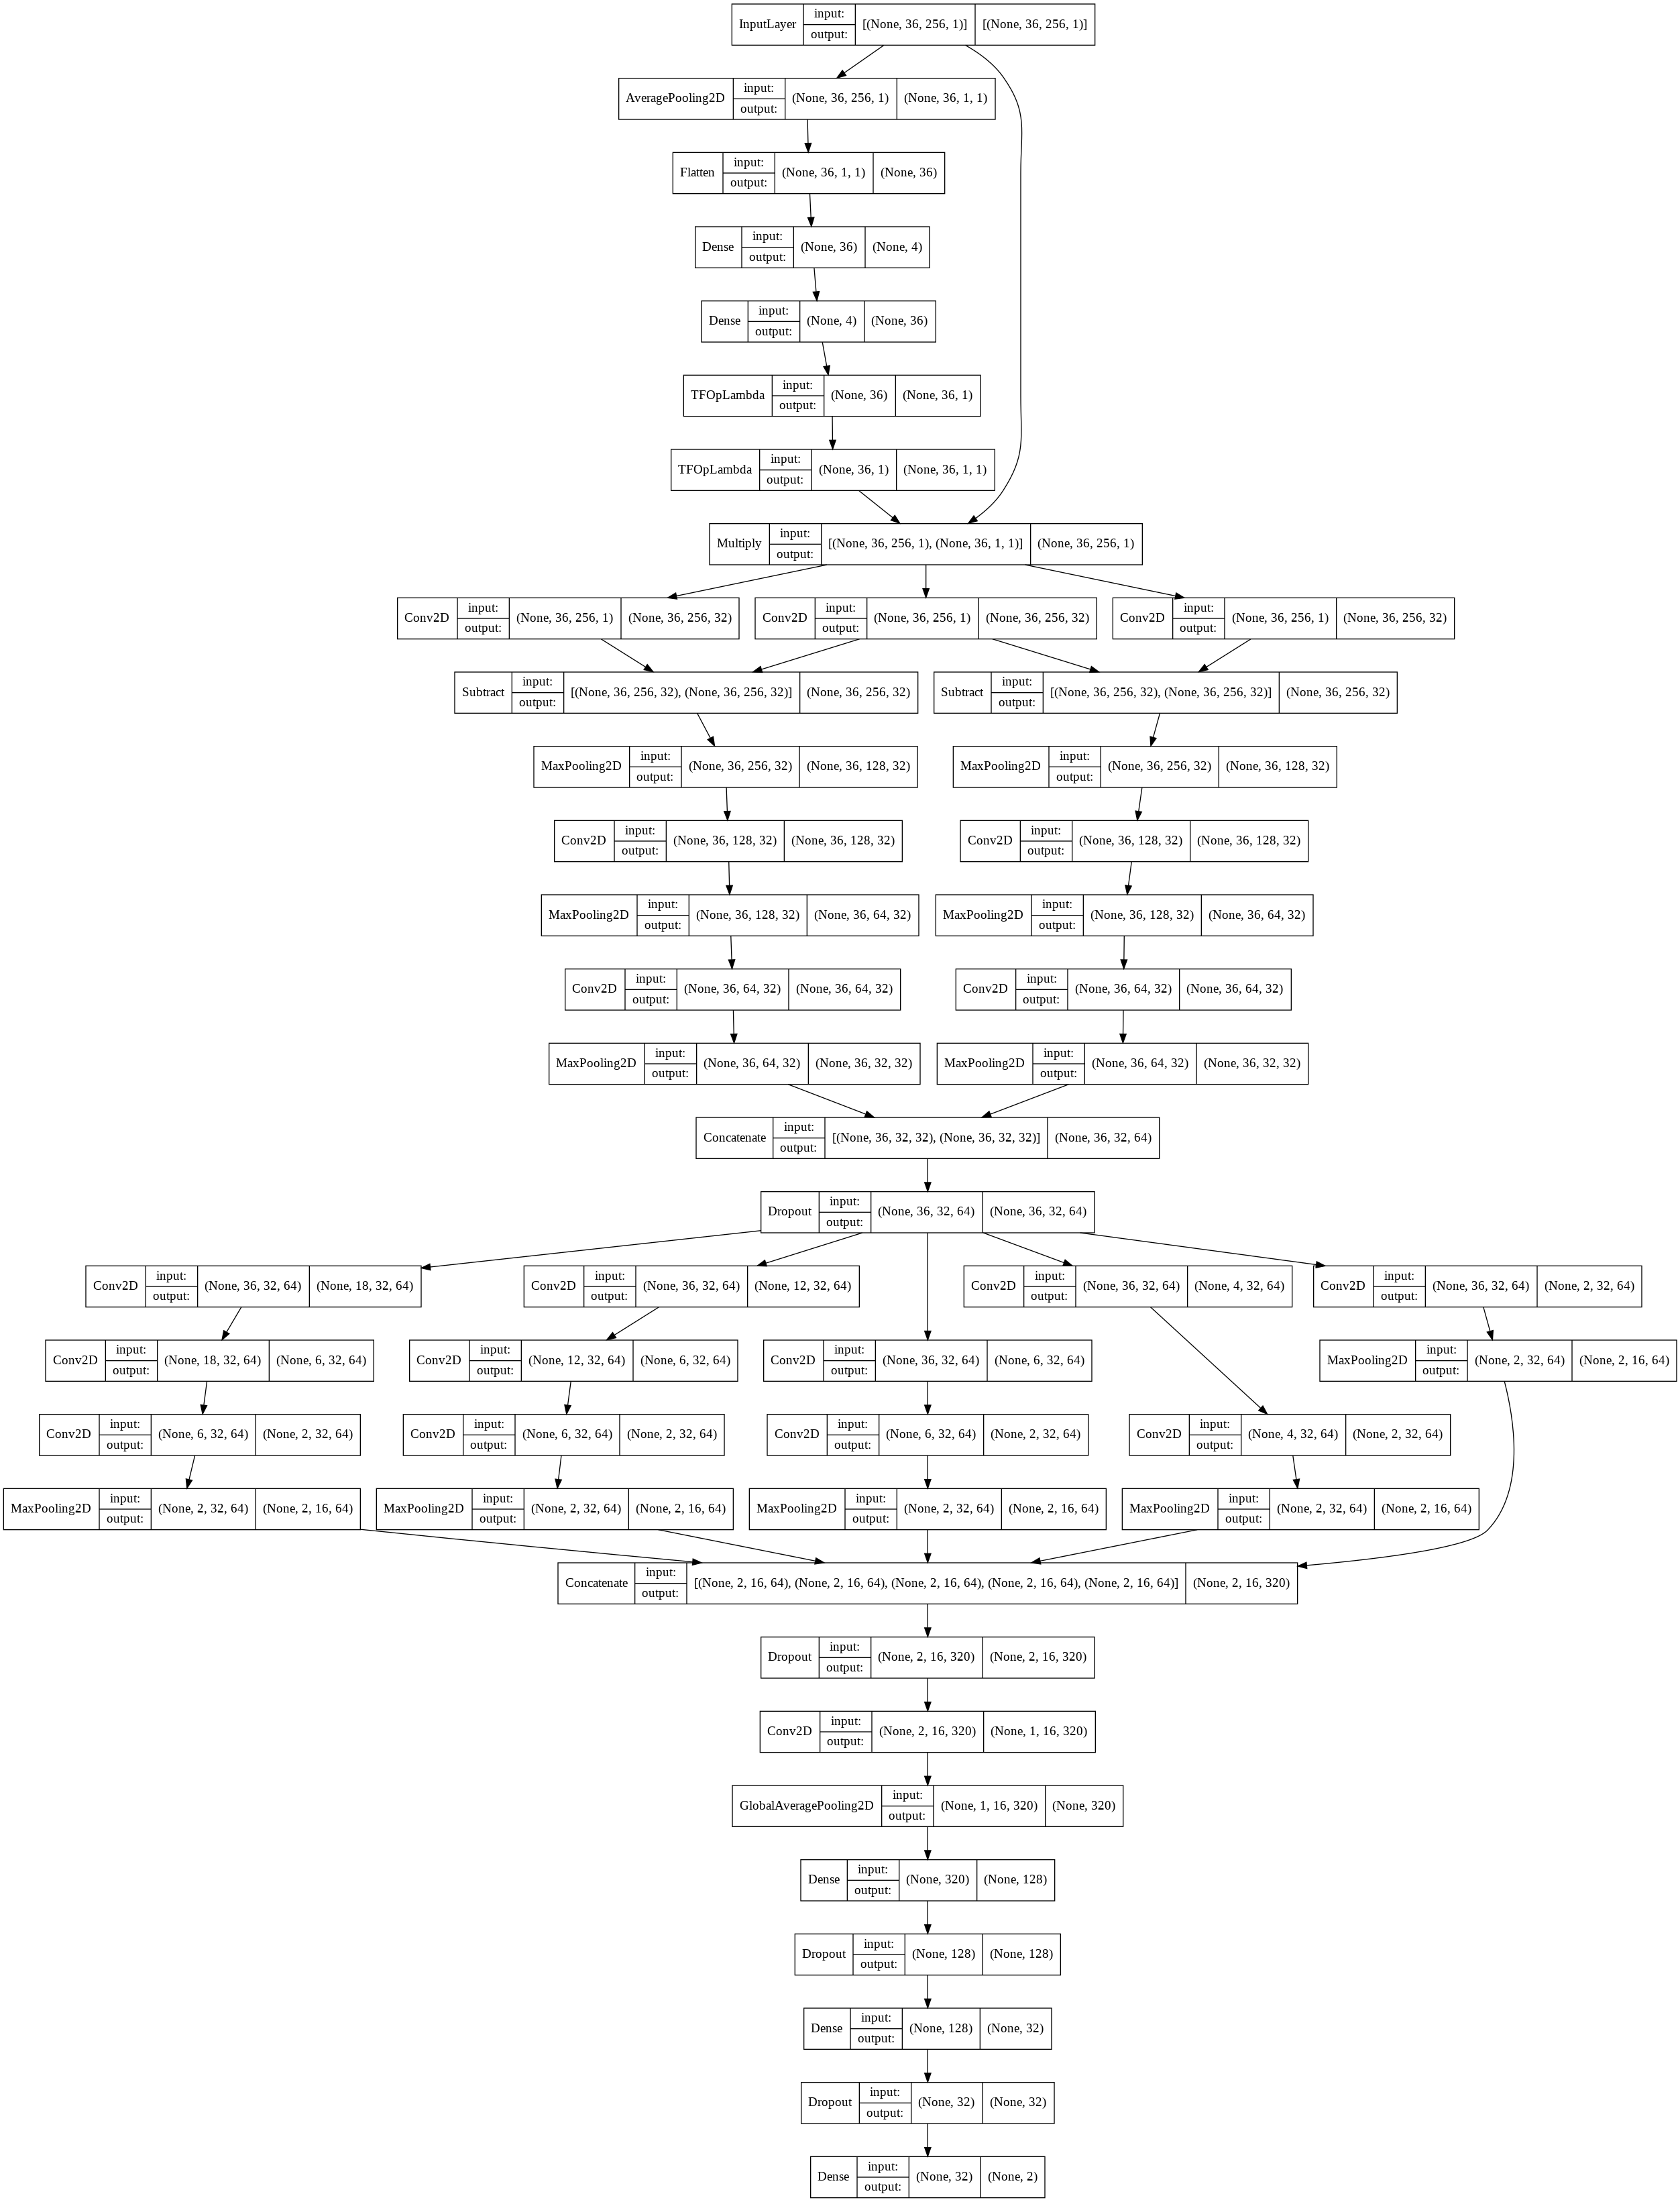

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
batch_size = 64
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

16018

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256) (120, 36, 256) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 4s 130ms/step - loss: 0.6963 - accuracy: 0.5247 - val_loss: 0.6091 - val_accuracy: 0.7500
Epoch 2/100
16/16 [==============================] - 2s 109ms/step - loss: 0.6096 - accuracy: 0.6759 - val_loss: 0.5554 - val_accuracy: 0.7778
Epoch 3/100
16/16 [==============================] - 2s 110ms/step - loss: 0.5764 - accuracy: 0.7047 - val_loss: 0.6003 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 2s 110ms/step - loss: 0.4978 - accuracy: 0.7675 - val_loss: 0.5207 - val_accuracy: 0.7500
Epoch 5/100
16/16 [==============================] - 2s 110ms/step - loss: 0.4548 - accuracy: 0.7788 - val_loss: 0.4414 - val_accuracy: 0.8148
Epoch 6/100
16/16 [==============================] - 2s 110ms/step - loss: 0.4224 - accuracy: 0.8261 - val_loss: 0.4428 - val_accuracy: 0.8056
Epoch 7/100
16/16 [==============================] - 2s 110ms/step - loss: 0.3038 - accuracy: 0.8827 - val_loss: 0.4411 - v

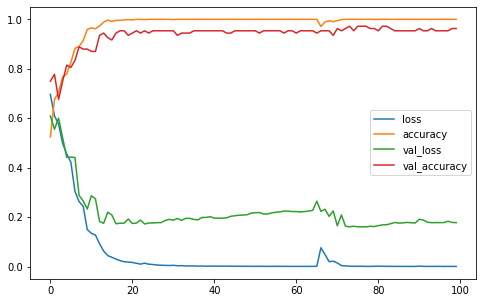

Results for fold 2
Epoch 1/100
16/16 [==============================] - 4s 131ms/step - loss: 0.6743 - accuracy: 0.5905 - val_loss: 0.5856 - val_accuracy: 0.7130
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 0.5592 - accuracy: 0.7140 - val_loss: 0.4877 - val_accuracy: 0.8056
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 0.4673 - accuracy: 0.7881 - val_loss: 0.4158 - val_accuracy: 0.8148
Epoch 4/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3629 - accuracy: 0.8776 - val_loss: 0.3752 - val_accuracy: 0.8056
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.2899 - accuracy: 0.9105 - val_loss: 0.2750 - val_accuracy: 0.8981
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 0.2176 - accuracy: 0.9259 - val_loss: 0.2275 - val_accuracy: 0.9074
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 0.1510 - accuracy: 0.9599 - val_loss: 0.2064 - v

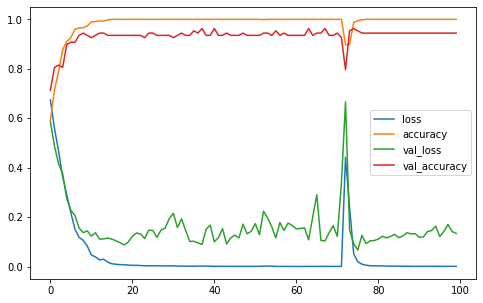

Results for fold 3
Epoch 1/100
16/16 [==============================] - 4s 132ms/step - loss: 0.7312 - accuracy: 0.5525 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6435 - accuracy: 0.6574 - val_loss: 0.6079 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5811 - accuracy: 0.7099 - val_loss: 0.5181 - val_accuracy: 0.7500
Epoch 4/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5265 - accuracy: 0.7418 - val_loss: 0.4487 - val_accuracy: 0.7963
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.4384 - accuracy: 0.8117 - val_loss: 0.3519 - val_accuracy: 0.8611
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3373 - accuracy: 0.8827 - val_loss: 0.2607 - val_accuracy: 0.9167
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 0.2603 - accuracy: 0.9126 - val_loss: 0.2139 - v

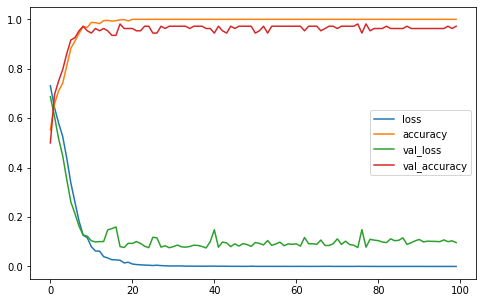

Results for fold 4
Epoch 1/100
16/16 [==============================] - 4s 133ms/step - loss: 0.7084 - accuracy: 0.5504 - val_loss: 0.6300 - val_accuracy: 0.7593
Epoch 2/100
16/16 [==============================] - 2s 113ms/step - loss: 0.6096 - accuracy: 0.6780 - val_loss: 0.5264 - val_accuracy: 0.7778
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 0.5446 - accuracy: 0.7387 - val_loss: 0.4842 - val_accuracy: 0.8241
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4439 - accuracy: 0.8117 - val_loss: 0.3522 - val_accuracy: 0.9167
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3328 - accuracy: 0.8827 - val_loss: 0.2890 - val_accuracy: 0.9167
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2584 - accuracy: 0.9064 - val_loss: 0.2132 - val_accuracy: 0.9259
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.1925 - accuracy: 0.9444 - val_loss: 0.1708 - v

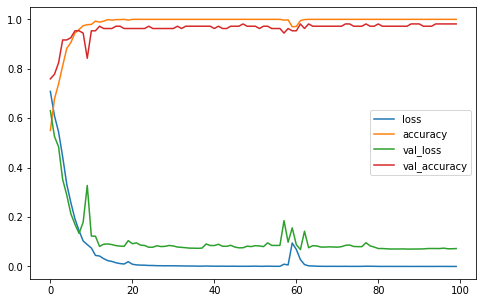

Results for fold 5
Epoch 1/100
16/16 [==============================] - 4s 134ms/step - loss: 0.7145 - accuracy: 0.5401 - val_loss: 0.6544 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 0.6213 - accuracy: 0.6605 - val_loss: 0.5999 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5391 - accuracy: 0.7407 - val_loss: 0.4861 - val_accuracy: 0.7870
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4302 - accuracy: 0.8230 - val_loss: 0.4961 - val_accuracy: 0.7500
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3348 - accuracy: 0.8693 - val_loss: 0.3576 - val_accuracy: 0.8426
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2378 - accuracy: 0.9218 - val_loss: 0.2229 - val_accuracy: 0.9352
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.1816 - accuracy: 0.9486 - val_loss: 0.2837 - v

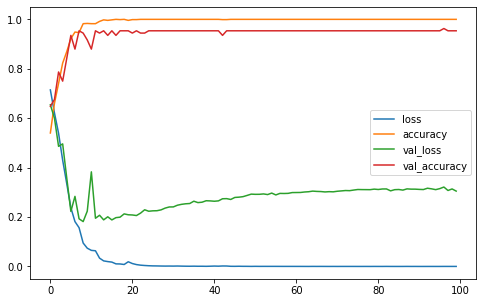

Results for fold 6
Epoch 1/100
16/16 [==============================] - 4s 133ms/step - loss: 0.7086 - accuracy: 0.5679 - val_loss: 0.7228 - val_accuracy: 0.4259
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 0.6236 - accuracy: 0.6955 - val_loss: 0.5673 - val_accuracy: 0.7685
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5447 - accuracy: 0.7767 - val_loss: 0.4689 - val_accuracy: 0.8241
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4502 - accuracy: 0.8261 - val_loss: 0.4106 - val_accuracy: 0.8519
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3685 - accuracy: 0.8539 - val_loss: 0.3140 - val_accuracy: 0.9167
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2695 - accuracy: 0.9146 - val_loss: 0.2007 - val_accuracy: 0.9352
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.1937 - accuracy: 0.9506 - val_loss: 0.2364 - v

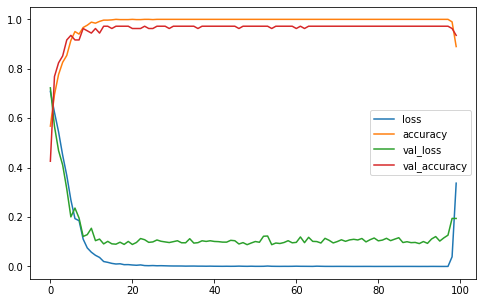

Results for fold 7
Epoch 1/100
16/16 [==============================] - 4s 133ms/step - loss: 0.7057 - accuracy: 0.5710 - val_loss: 0.6863 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 2s 114ms/step - loss: 0.6047 - accuracy: 0.6553 - val_loss: 0.5563 - val_accuracy: 0.7222
Epoch 3/100
16/16 [==============================] - 2s 114ms/step - loss: 0.5023 - accuracy: 0.7706 - val_loss: 0.4678 - val_accuracy: 0.8056
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4091 - accuracy: 0.8354 - val_loss: 0.3622 - val_accuracy: 0.8611
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3068 - accuracy: 0.8971 - val_loss: 0.2808 - val_accuracy: 0.8889
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2322 - accuracy: 0.9249 - val_loss: 0.1875 - val_accuracy: 0.9815
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.1833 - accuracy: 0.9414 - val_loss: 0.1987 - v

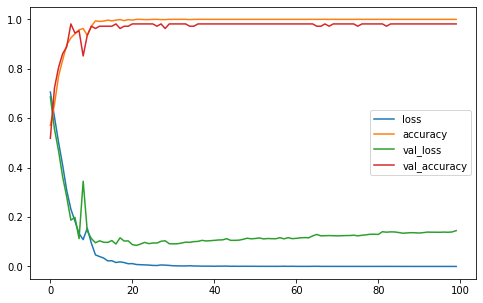

Results for fold 8
Epoch 1/100
16/16 [==============================] - 4s 134ms/step - loss: 0.7196 - accuracy: 0.5967 - val_loss: 0.6146 - val_accuracy: 0.7407
Epoch 2/100
16/16 [==============================] - 2s 114ms/step - loss: 0.5879 - accuracy: 0.6708 - val_loss: 0.4747 - val_accuracy: 0.8148
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 0.5036 - accuracy: 0.7685 - val_loss: 0.3937 - val_accuracy: 0.8611
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4223 - accuracy: 0.8241 - val_loss: 0.3594 - val_accuracy: 0.8889
Epoch 5/100
16/16 [==============================] - 2s 114ms/step - loss: 0.3400 - accuracy: 0.8889 - val_loss: 0.2704 - val_accuracy: 0.9074
Epoch 6/100
16/16 [==============================] - 2s 114ms/step - loss: 0.2647 - accuracy: 0.9167 - val_loss: 0.2797 - val_accuracy: 0.8981
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2127 - accuracy: 0.9393 - val_loss: 0.2199 - v

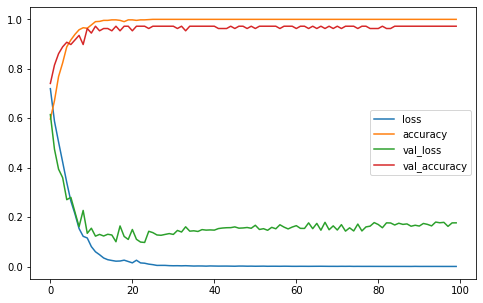

Results for fold 9
Epoch 1/100
16/16 [==============================] - 4s 136ms/step - loss: 0.7024 - accuracy: 0.5700 - val_loss: 0.6257 - val_accuracy: 0.6574
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6355 - accuracy: 0.6667 - val_loss: 0.5559 - val_accuracy: 0.7130
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5515 - accuracy: 0.7582 - val_loss: 0.4921 - val_accuracy: 0.7963
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4789 - accuracy: 0.7922 - val_loss: 0.4363 - val_accuracy: 0.8148
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3672 - accuracy: 0.8673 - val_loss: 0.3189 - val_accuracy: 0.8704
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2721 - accuracy: 0.9136 - val_loss: 0.2758 - val_accuracy: 0.9167
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2209 - accuracy: 0.9156 - val_loss: 0.2102 - v

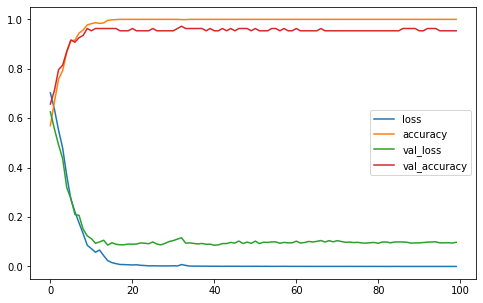

Results for fold 10
Epoch 1/100
16/16 [==============================] - 4s 136ms/step - loss: 0.6667 - accuracy: 0.5874 - val_loss: 0.6213 - val_accuracy: 0.6944
Epoch 2/100
16/16 [==============================] - 2s 114ms/step - loss: 0.6063 - accuracy: 0.7088 - val_loss: 0.4926 - val_accuracy: 0.7778
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 0.5241 - accuracy: 0.7407 - val_loss: 0.4944 - val_accuracy: 0.7593
Epoch 4/100
16/16 [==============================] - 2s 114ms/step - loss: 0.4478 - accuracy: 0.8014 - val_loss: 0.3674 - val_accuracy: 0.8611
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3495 - accuracy: 0.8735 - val_loss: 0.2639 - val_accuracy: 0.9259
Epoch 6/100
16/16 [==============================] - 2s 114ms/step - loss: 0.2524 - accuracy: 0.9177 - val_loss: 0.1982 - val_accuracy: 0.9444
Epoch 7/100
16/16 [==============================] - 2s 114ms/step - loss: 0.1882 - accuracy: 0.9393 - val_loss: 0.1422 - 

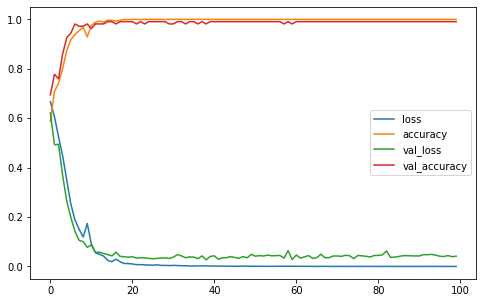

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9516666412353516
F1_Score  : 0.9437556463263543


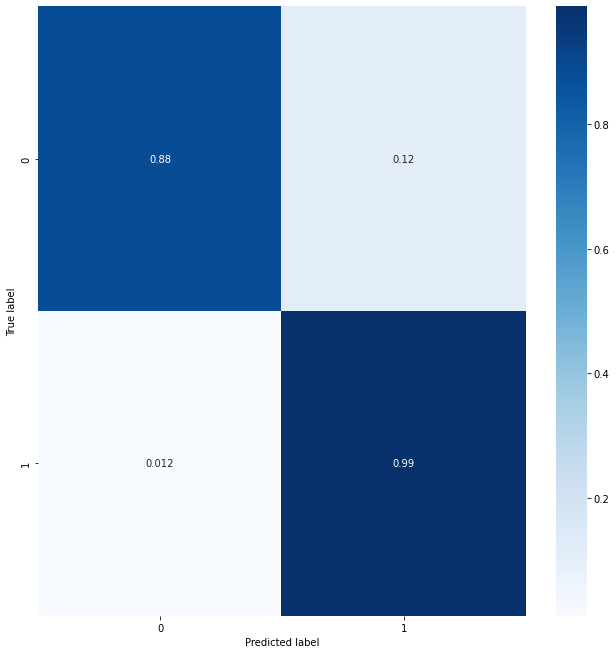

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256) (120, 36, 256) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 4s 132ms/step - loss: 0.6814 - accuracy: 0.5597 - val_loss: 0.6483 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 0.6252 - accuracy: 0.6656 - val_loss: 0.5613 - val_accuracy: 0.7778
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 0.5536 - accuracy: 0.7407 - val_loss: 0.5055 - val_accuracy: 0.7870
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 0.5072 - accuracy: 0.7572 - val_loss: 0.4513 - val_accuracy: 0.8056
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.4302 - accuracy: 0.8014 - val_loss: 0.3854 - val_accuracy: 0.8333
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3178 - accuracy: 0.8848 - val_loss: 0.2861 - val_accuracy: 0.8981
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 0.2521 - accuracy: 0.9167 - val_loss: 0.2744 - v

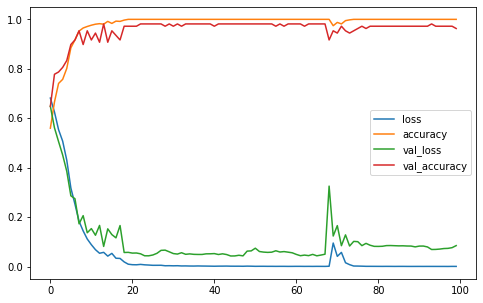

Results for fold 2
Epoch 1/100
16/16 [==============================] - 4s 141ms/step - loss: 0.7093 - accuracy: 0.5278 - val_loss: 0.6583 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 0.6707 - accuracy: 0.6070 - val_loss: 0.6704 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6277 - accuracy: 0.6564 - val_loss: 0.6586 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 0.5798 - accuracy: 0.7191 - val_loss: 0.5492 - val_accuracy: 0.7870
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5053 - accuracy: 0.7912 - val_loss: 0.4741 - val_accuracy: 0.8056
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 0.4569 - accuracy: 0.7994 - val_loss: 0.4059 - val_accuracy: 0.8796
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3832 - accuracy: 0.8683 - val_loss: 0.3793 - v

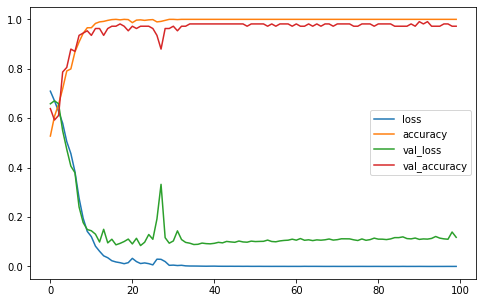

Results for fold 3
Epoch 1/100
16/16 [==============================] - 4s 134ms/step - loss: 0.6874 - accuracy: 0.5628 - val_loss: 0.6640 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6276 - accuracy: 0.6543 - val_loss: 0.5585 - val_accuracy: 0.7500
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 0.5500 - accuracy: 0.7377 - val_loss: 0.4646 - val_accuracy: 0.8333
Epoch 4/100
16/16 [==============================] - 2s 112ms/step - loss: 0.4553 - accuracy: 0.8230 - val_loss: 0.3990 - val_accuracy: 0.8241
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3833 - accuracy: 0.8529 - val_loss: 0.3307 - val_accuracy: 0.8704
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2958 - accuracy: 0.9012 - val_loss: 0.2766 - val_accuracy: 0.9074
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2085 - accuracy: 0.9455 - val_loss: 0.2175 - v

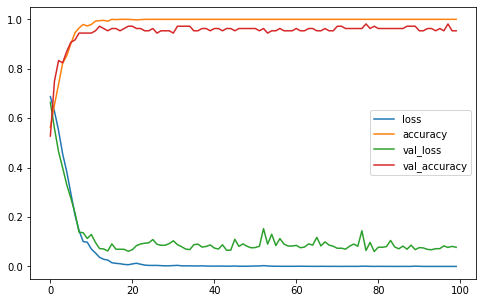

Results for fold 4
Epoch 1/100
16/16 [==============================] - 4s 139ms/step - loss: 0.6986 - accuracy: 0.5247 - val_loss: 0.6993 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 0.6314 - accuracy: 0.6533 - val_loss: 0.6499 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 0.5905 - accuracy: 0.6944 - val_loss: 0.5824 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 0.5152 - accuracy: 0.7623 - val_loss: 0.6567 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.4870 - accuracy: 0.7572 - val_loss: 0.3973 - val_accuracy: 0.8333
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3684 - accuracy: 0.8580 - val_loss: 0.3738 - val_accuracy: 0.8611
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2946 - accuracy: 0.9023 - val_loss: 0.2268 - v

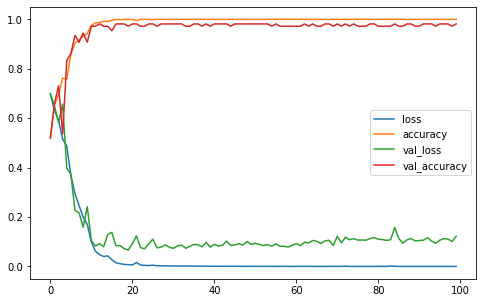

Results for fold 5
Epoch 1/100
16/16 [==============================] - 4s 142ms/step - loss: 0.7242 - accuracy: 0.5113 - val_loss: 0.6475 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6302 - accuracy: 0.6265 - val_loss: 0.5898 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5776 - accuracy: 0.6903 - val_loss: 0.5412 - val_accuracy: 0.7778
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.5144 - accuracy: 0.7685 - val_loss: 0.5121 - val_accuracy: 0.7685
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4498 - accuracy: 0.8035 - val_loss: 0.4346 - val_accuracy: 0.8426
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3567 - accuracy: 0.8745 - val_loss: 0.3611 - val_accuracy: 0.8796
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2733 - accuracy: 0.9064 - val_loss: 0.3157 - v

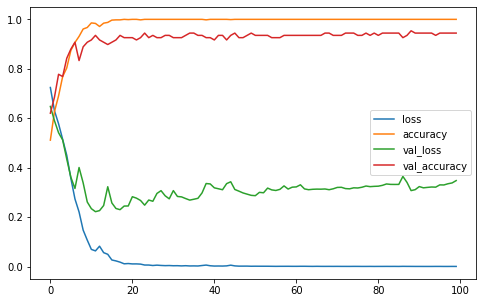

Results for fold 6
Epoch 1/100
16/16 [==============================] - 4s 133ms/step - loss: 0.7004 - accuracy: 0.5453 - val_loss: 0.6764 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 0.6683 - accuracy: 0.5772 - val_loss: 0.6333 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6102 - accuracy: 0.7058 - val_loss: 0.5534 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.5531 - accuracy: 0.7294 - val_loss: 0.4611 - val_accuracy: 0.8056
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.4878 - accuracy: 0.7809 - val_loss: 0.4131 - val_accuracy: 0.8426
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3909 - accuracy: 0.8467 - val_loss: 0.3199 - val_accuracy: 0.8796
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3107 - accuracy: 0.8704 - val_loss: 0.2529 - v

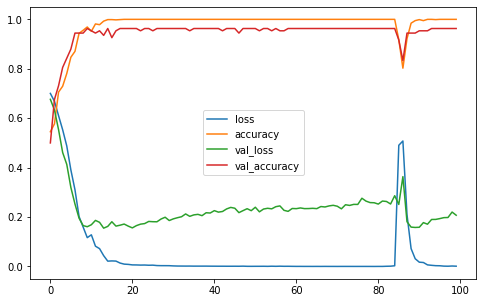

Results for fold 7
Epoch 1/100
16/16 [==============================] - 4s 134ms/step - loss: 0.6790 - accuracy: 0.5679 - val_loss: 0.6271 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 2s 113ms/step - loss: 0.6266 - accuracy: 0.6512 - val_loss: 0.5923 - val_accuracy: 0.7315
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 0.6062 - accuracy: 0.6790 - val_loss: 0.6367 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.5663 - accuracy: 0.6893 - val_loss: 0.5505 - val_accuracy: 0.7315
Epoch 5/100
16/16 [==============================] - 2s 114ms/step - loss: 0.4701 - accuracy: 0.7809 - val_loss: 0.4658 - val_accuracy: 0.8148
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3566 - accuracy: 0.8591 - val_loss: 0.3800 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 2s 114ms/step - loss: 0.2487 - accuracy: 0.9270 - val_loss: 0.3288 - v

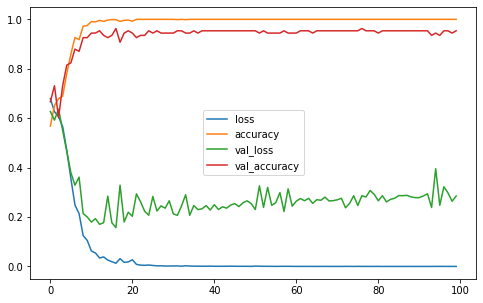

Results for fold 8
Epoch 1/100
16/16 [==============================] - 4s 132ms/step - loss: 0.6965 - accuracy: 0.5278 - val_loss: 0.6702 - val_accuracy: 0.6574
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6645 - accuracy: 0.6142 - val_loss: 0.6345 - val_accuracy: 0.7222
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 0.6186 - accuracy: 0.6626 - val_loss: 0.5943 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5712 - accuracy: 0.7150 - val_loss: 0.5621 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5190 - accuracy: 0.7449 - val_loss: 0.4215 - val_accuracy: 0.8611
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4226 - accuracy: 0.8302 - val_loss: 0.3332 - val_accuracy: 0.8889
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3490 - accuracy: 0.8735 - val_loss: 0.3130 - v

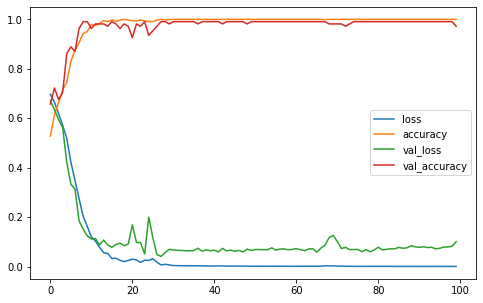

Results for fold 9
Epoch 1/100
16/16 [==============================] - 4s 136ms/step - loss: 0.7050 - accuracy: 0.5123 - val_loss: 0.7001 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6690 - accuracy: 0.5895 - val_loss: 0.6508 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6198 - accuracy: 0.6646 - val_loss: 0.6448 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 2s 114ms/step - loss: 0.5794 - accuracy: 0.6944 - val_loss: 0.5844 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 0.5136 - accuracy: 0.7582 - val_loss: 0.4865 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 2s 114ms/step - loss: 0.4411 - accuracy: 0.8025 - val_loss: 0.4945 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.3638 - accuracy: 0.8611 - val_loss: 0.3413 - v

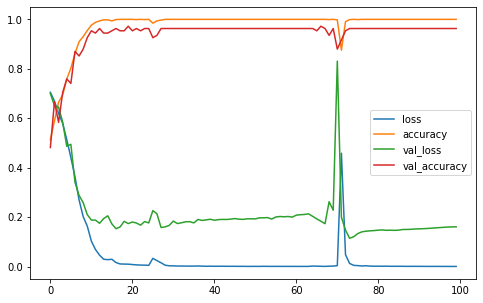

Results for fold 10
Epoch 1/100
16/16 [==============================] - 4s 132ms/step - loss: 0.6994 - accuracy: 0.5514 - val_loss: 0.6410 - val_accuracy: 0.6574
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6189 - accuracy: 0.6574 - val_loss: 0.5985 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.5384 - accuracy: 0.7572 - val_loss: 0.4931 - val_accuracy: 0.7870
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 0.4854 - accuracy: 0.7665 - val_loss: 0.4176 - val_accuracy: 0.8519
Epoch 5/100
16/16 [==============================] - 2s 114ms/step - loss: 0.3755 - accuracy: 0.8704 - val_loss: 0.3438 - val_accuracy: 0.8519
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 0.3001 - accuracy: 0.9136 - val_loss: 0.3545 - val_accuracy: 0.8704
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.2508 - accuracy: 0.9228 - val_loss: 0.2368 - 

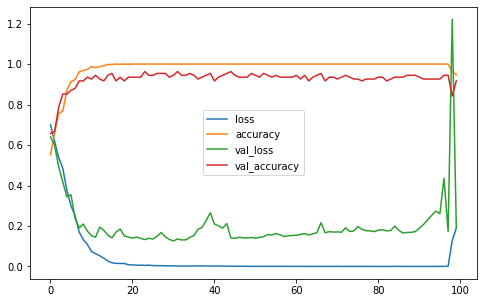

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.978333342075348
F1_Score  : 0.9782330318972011


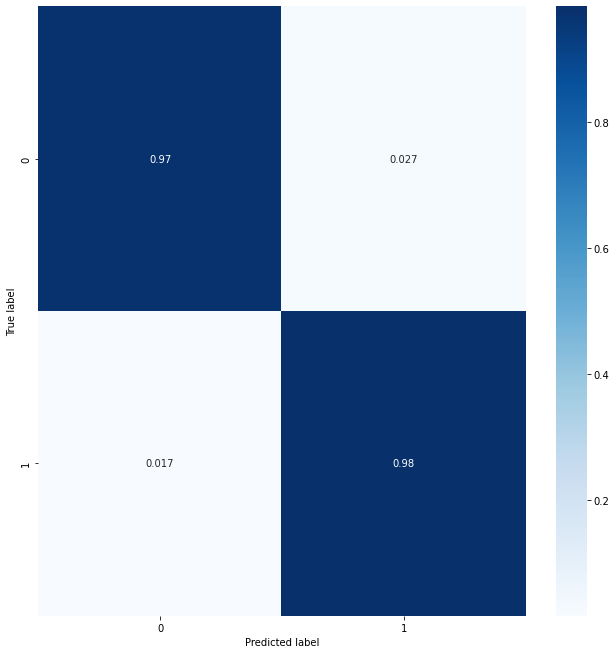

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()